# Volume 4: Total Variation
    Benj McMullin
    Math 439
    2/15/2024


In [2]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from matplotlib import cm
from imageio import imread, imwrite
import imageio as im
from PIL import Image, ImageOps

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problem 1

Using $20$ $x$ steps, $250$ time steps, $a=-1$, $b=1$, $\alpha = 1$, $\beta=7$, and a final time of $0.2$, plot the solution that minimizes (17.4). It should match figure 17.1.

In [3]:
# Initialize parameters
a, b = -1, 1
alpha, beta = 1, 7
final_T = 0.2
time_steps = 250
x_steps = 20

# Calculate time and space step sizes
dt = final_T / time_steps
dx = (b - a) / x_steps

# Create grid points along x-axis
x0 = np.linspace(a, b, x_steps + 1)

# Calculate initial values of y using linear interpolation
y0 = (beta - alpha) / (b - a) * (x0 - a) + alpha

In [4]:
# Check stability condition
if dt / dx ** 2 > 0.5:
    print("Stability Condition Fails")

# Initialize u array with two rows and x_steps + 1 columns
u = np.empty((2, x_steps + 1))

# Initialize u with initial values using linear interpolation
u[0] = (beta - alpha) / (b - a) * (x0 - a) + alpha
u[1] = (beta - alpha) / (b - a) * (x0 - a) + alpha


In [5]:
def rhs(y):
    # Compute first and second derivatives using central difference scheme
    yp = (np.roll(y, -1) - np.roll(y, 1)) / (2 * dx)
    ypp = (np.roll(y, -1) - 2 * y + np.roll(y, 1)) / dx ** 2
    
    # Update interior points using forward Euler scheme
    y[1:-1] -= dt * (1 + yp[1:-1] ** 2 - y[1:-1] * ypp[1:-1])
    
# Iterate until convergence or maximum time steps reached
for i in range(time_steps):
    rhs(u[1])  # Update u[1] using rhs function
    if la.norm(np.abs((u[0] - u[1]))) < 1e-5:
        break
    u[0] = u[1]  # Update previous solution with current solution
    
# Print final iteration difference and time
print("Difference in iteration is ", la.norm(np.abs((u[0] - u[1]))))
print("Final time = ", i * dt)


Difference in iteration is  0.0
Final time =  0.19920000000000002


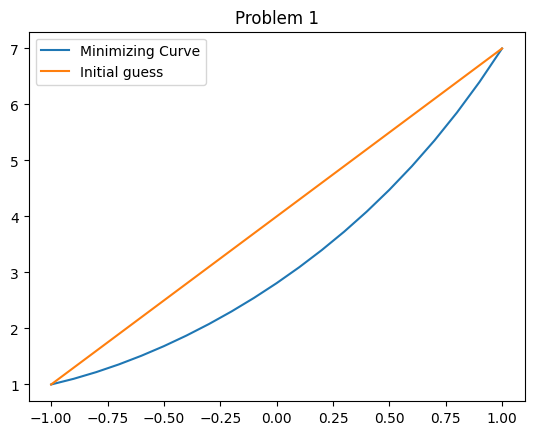

In [6]:
# Plot the minimizing curve and initial guess
plt.plot(x0, u[-1], label="Minimizing Curve")  # Plot the final solution
plt.plot(x0, y0, label="Initial guess")  # Plot the initial guess
plt.title("Problem 1")  # Set the title of the plot
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot

# Problem 2

Using $\Delta t = 1e{-3},$ $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$. (So $\Omega = [0,n_x]\times [0,n_y]$, where $n_x$ and $n_y$ represent the number of pixels in the $x$ and $y$ dimensions, respectively.) Take 250 steps in time. Plot the original image as well as the image with noise. Compare your results with Figure 17.3.

In [7]:
# Define the image filename and the number of pixels to change
imagename = 'balloons_color.jpg'
changed_pixels = 40000

# Read the image file `imagename` into an array of numbers, IM
# Multiply by 1. / 255 to change the values so that they are floating-point
# numbers ranging from 0 to 1.
IM = imread(imagename, mode='L') * (1. / 255)
IM_x, IM_y = IM.shape

# Add noise to random pixels in the image
for lost in range(changed_pixels):
    # Generate random coordinates within the image boundaries
    x_, y_ = np.random.randint(1, IM_x - 2), np.random.randint(1, IM_y - 2)
    
    # Generate random noise value with mean 0 and standard deviation 0.1
    val = 0.1 * np.random.randn() + 0.5
    
    # Ensure the pixel value is within [0, 1] range and update the image
    IM[x_, y_] = max(min(val, 1.), 0.)

# Scale the values back to the range [0, 255] and convert to uint8
IM *= 255
IM = IM.astype('uint8')

# Save the noisy image
imwrite("noised_" + imagename, IM)

C:\Users\benja\AppData\Local\Temp\ipykernel_8232\2236453871.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  IM = imread(imagename, mode='L') * (1. / 255)


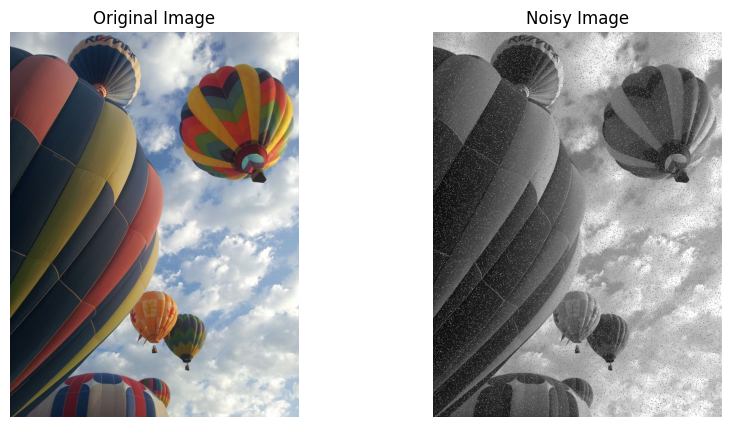

In [8]:
# Plot both images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
original_im = Image.open(imagename)
plt.imshow(original_im, cmap='gray')
plt.axis("off")
plt.title("Original Image")

# Plot the noisy image
plt.subplot(1, 2, 2)
noisy_im = Image.open("noised_" + imagename)
plt.imshow(noisy_im, cmap='gray')
plt.axis("off")
plt.title("Noisy Image")

plt.show()

In [9]:
# Initialize parameters
dt = 1e-3  # Time step
lam = 40   # Diffusion coefficient
dx = 1     # Grid spacing in x direction
dy = 1     # Grid spacing in y direction
time_steps = 250  # Number of time steps

# Check stability condition
if dt / dx ** 2 > 0.5:
    print("Stability condition fails")

# Load the noisy image
IM = imread("noised_" + imagename, mode='L') * (1. / 255)

# Define the right-hand side of the diffusion equation
def rhs(u):
    uxx = (np.roll(u, -1, axis=1) - 2 * u + np.roll(u, 1, axis=1)) / dx ** 2
    uyy = (np.roll(u, -1, axis=0) - 2 * u + np.roll(u, 1, axis=0)) / dy ** 2
    ut = -(u - IM - lam * (uxx + uyy))
    u[1:-1, 1:-1] += dt * ut[1:-1, 1:-1]
    return u

# Run the diffusion approach
for i in range(time_steps):
    old_image = IM.copy()  # Store the previous state of u
    IM = rhs(IM)            # Compute the next state of u
    # Check for convergence
    if la.norm(np.abs((IM - old_image))) < 1e-5:
        break

C:\Users\benja\AppData\Local\Temp\ipykernel_8232\1655311343.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  IM = imread("noised_" + imagename, mode='L') * (1. / 255)


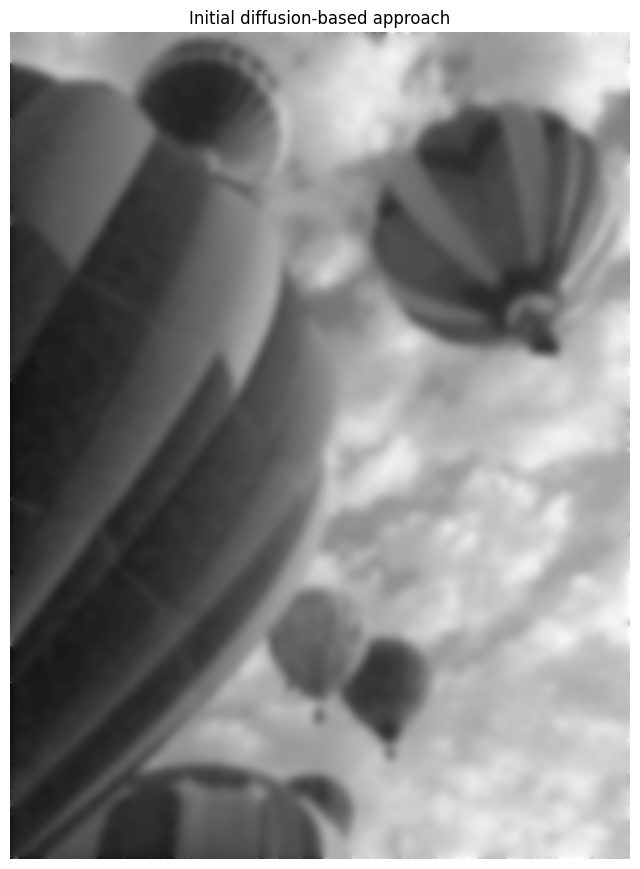

In [11]:
# Plot it
u_new = IM
plt.figure(figsize=(8,12))
plt.imshow(u_new, cmap='gray')
plt.title("Initial diffusion-based approach")
plt.axis("off")
plt.show()

# Problem 3

Using $\Delta t = 1e-3, \lambda = 1, \Delta x = 1,$ and $ \Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$.  Take 200 steps in time. Display both the diffusion-based and total variaton images of the balloon. Compare your results with
Figure 17.3. How small should ε be?

C:\Users\benja\AppData\Local\Temp\ipykernel_8232\3603260723.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  IM1 = imread("noised_" + imagename, mode='L') * (1. / 255)


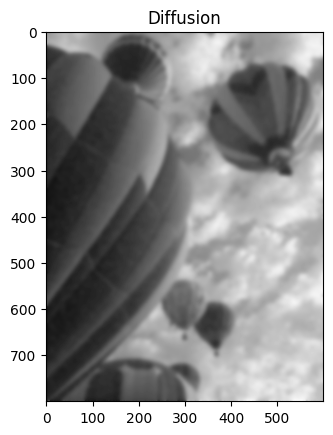

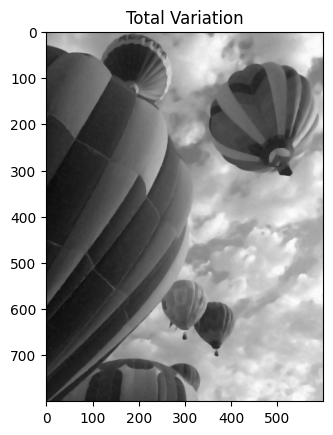

In [14]:
prob2 = np.copy(u_new)  # Save diffusion solution
u = np.copy(IM)  # Get the image, reset the problem

# Parameters for the total variation approach
delta_t = 1e-03  # Time step size
lamb = 1  # Regularization parameter
delta_x = 1  # Spacial step size in the x-direction
delta_y = 1  # Spacial step size in the y-direction
time_steps = 200  # Number of time steps

if delta_t / delta_x ** 2 > 0.5:
    print("Stability condition fails")

IM1 = imread("noised_" + imagename, mode='L') * (1. / 255)

# Function to compute the right-hand side of the total variation equation
def rhs(u):
    # Compute spatial derivatives
    u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / 2
    u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / 2
    
    u_xx = (np.roll(u, -1, axis=1) - 2 * u + np.roll(u, 1, axis=1))/delta_x**2
    u_yy = (np.roll(u, -1, axis=0) - 2 * u + np.roll(u, 1, axis=0))/delta_y**2
    
    u_xy = (np.roll(u_x, -1, axis=0) - np.roll(u_x, 1, axis=0)) / (2.*delta_y*delta_x)
    
    # Compute numerator and denominator for the update equation
    numer = u_xx * u_y**2 + u_yy * u_x**2 - 2 * u_x * u_y * u_xy
    denom = (1e-4 + u_x**2. + u_y**2.)**(3 / 2)  # Add 1e-04 to denominator for numerical stability
    
    # Update the solution using the total variation approach
    ut = (-lamb * (u - IM1) + numer / denom)

    u[1:-1, 1:-1] += delta_t * ut[1:-1, 1:-1]
    return u

# Iterate over time steps to solve the total variation equation
for i in range(time_steps):
    old_image = IM1.copy()  # Store the previous state of u
    IM1 = rhs(IM1)  # Compute the next state of u

    if np.linalg.norm(np.abs((IM1 - old_image))) < 1e-5: 
        break

plt.title("Diffusion")
plt.imshow(prob2, cmap="gray")
plt.show()

plt.title("Total Variation")
plt.imshow(IM1, cmap="gray")
plt.show()